# _*Vehicle Routing*_

## The Introduction

Logistics is a major industry, with some estimates valuing it at USD 8183 billion globally in 2015. Most service providers operate a number of vehicles (e.g., trucks and container ships), a number of depots, where the vehicles are based overnight, and serve a number of client locations with each vehicle during each day. There are many optimization and control problems that consider these parameters. Computationally, the key challenge is how to design routes from depots to a number of client locations and back to the depot, so as to minimize vehicle-miles traveled, time spent, or similar objective functions. In this notebook we formalize an idealized version of the problem and showcase its solution using the quantum approximate optimization approach of Farhi, Goldstone, and Gutman (2014). 

The overall workflow we demonstrate comprises:

1. establish the client locations. Normally, these would be available ahead of the day of deliveries from a database. In our use case, we generate these randomly.

3. compute the pair-wise distances, travel times, or similar. In our case, we consider the Euclidean distance, "as the crow flies", which is perhaps the simplest possible.

4. compute the actual routes. This step is run twice, actually. First, we obtain a reference value by a run of a classical solver (IBM CPLEX) on the classical computer. Second, we run an alternative, hybrid algorithm partly on the quantum computer.

5. visualization of the results. In our case, this is again a simplistic plot.

In the following, we first explain the model, before we proceed with the installation of the pre-requisites and the data loading.

## The Model 

Mathematically speaking, the vehicle routing problem (VRP) is a combinatorial problem, wherein the best routes from a depot to a number of clients and back to the depot are sought, given a number of available vehicles. There are a number of formulations possible, extending a number of formulations of the traveling salesman problem [Applegate et al, 2006]. Here, we present a formulation known as MTZ [Miller, Tucker, Zemlin, 1960]. 

Let $n$ be the number of clients (indexed as $1,\dots,n$), and $K$ be the number of available vehicles. Let $x_{ij} = \{0,1\}$ be the binary decision variable which, if it is $1$, activates the segment from node $i$ to node $j$. The node index runs from $0$ to $n$, where $0$ is (by convention) the depot. There are twice as many distinct decision variables as edges. For example, in a fully connected graph, there are $n(n+1)$ binary decision variables. 

If two nodes $i$ and $j$ have a link from $i$ to $j$, we write $i \sim j$. We also denote with $\delta(i)^+$ the set of nodes to which $i$ has a link, i.e., $j \in \delta(i)^+$ if and only if $i \sim j$. Similarly, we denote with 
$\delta(i)^-$ the set of nodes which are connected to $i$, in the sense that $j \in \delta(i)^-$ if and only if $j \sim i$. 

In addition, we consider continuous variables, for all nodes $i = 1,\dots, n$, denoted $u_i$. These variables are needed in the MTZ formulation of the problem to eliminate sub-tours between clients. 

The VRP can be formulated as:

$$
(VRP) \quad  f = \min_{\{x_{ij}\}_{i\sim j}\in \{0,1\}, \{u_i\}_{i=1,\dots,n}\in \mathbb{R}} \quad \sum_{i \sim j} w_{ij} x_{ij}
$$

subject to the node-visiting constraint:

$$
\sum_{j \in \delta(i)^+} x_{ij} = 1, \,\sum_{j \in \delta(i)^-} x_{ji} = 1,\, \forall i \in \{1,\dots,n\},
$$

the depot-visiting constraints:

$$
\sum_{i \in \delta(0)^+} x_{0i} = K, \, \sum_{j \in \delta(0)^+} x_{j0} = K,
$$

and the sub-tour elimination constraints:

$$
u_i - u_j + Q x_{ij} \leq Q-q_j, \, \forall i \sim j, \,i ,j \neq 0, \quad q_i \leq u_i \leq Q,\, \forall i, i \neq 0.
$$

In particular, 
- The cost function is linear in the cost functions and weighs the different arches based on a positive weight $w_{ij}>0$ (typically the distance between node $i$ and node $j$);
- The first set of constraints enforce that from and to every client, only one link is allowed;
- The second set of constraints enforce that from and to the depot, exactly  $K$ links are allowed;
- The third set of constraints enforce the sub-tour elimination constraints and are bounds on $u_i$, with $Q>q_j>0$, and $Q,q_i \in \mathbb{R}$.


## Classical solution

We can solve the VRP classically, e.g., by using CPLEX. CPLEX uses a branch-and-bound-and-cut method to find an approximate solution of the VRP, which, in this formulation, is a mixed-integer linear program (MILP). For the sake of notation, we pack the decision variables in one vector as

$$
{\bf z} = [x_{01},x_{02},\ldots,x_{10}, x_{12},\ldots,x_{n(n-1)}]^T,
$$

wherein ${\bf z} \in \{0,1\}^N$, with $N = n (n+1)$. So the dimension of the problem scales quadratically with the number of nodes. Let us denote the optimal solution by ${\bf z}^*$, and the associated optimal cost $f^*$. 


## References

[1] E. Farhi, J. Goldstone, S. Gutmann e-print arXiv 1411.4028, 2014

[2] https://github.com/Qiskit/qiskit-tutorial/blob/master/qiskit/aqua/optimization/maxcut_and_tsp.ipynb

[3] C. E. Miller, E. W. Tucker, and R. A. Zemlin (1960). "Integer Programming Formulations and Travelling Salesman Problems". J. ACM. 7: 326–329. doi:10.1145/321043.321046.

[4] D. L. Applegate, R. M. Bixby, V. Chvátal, and W. J. Cook (2006). The Traveling Salesman Problem. Princeton University Press, ISBN 978-0-691-12993-8.

## Initialization

First of all we load all the packages that we need: 
  - Python 3.6 or greater is required;
  - CPLEX 12.8 or greater is required for the classical computations;

In [1]:
# Load the packages that are required
import numpy as np
import operator
import matplotlib.pyplot as plt

import sys
if sys.version_info < (3, 6):
    raise Exception('Please use Python version 3.6 or greater.')

try:
    import cplex
    from cplex.exceptions import CplexError
except: 
    print("Warning: Cplex not found.")
import math


We then initialize the variables

In [2]:
# Initialize the problem by defining the parameters
n = 10  # number of nodes + depot (n+1)
K = 2  # number of vehicles

We define an initializer class that randomly places the nodes in a 2-D plane and computes the distance between them. 

In [3]:
# Get the data
class Initializer():

    def __init__(self, n):
        self.n = n

    def generate_instance(self):

        n = self.n

        # np.random.seed(33)
        np.random.seed(1543)

        xc = (np.random.rand(n) - 0.5) * 10 # random generation of x-coordinates for each node
        yc = (np.random.rand(n) - 0.5) * 10 # random generation of y-coordinates for each node

        instance = np.zeros([n, n])
        for ii in range(0, n):
            for jj in range(ii + 1, n):
                instance[ii, jj] = (xc[ii] - xc[jj]) ** 2 + (yc[ii] - yc[jj]) ** 2  #generation of the adjacency matrix
                instance[jj, ii] = instance[ii, jj]

        return xc, yc, instance

In [4]:
# Initialize the problem by randomly generating the instance
initializer = Initializer(n)
xc,yc,instance = initializer.generate_instance()

## Classical solution using IBM ILOG CPLEX

For a classical solution, we use IBM ILOG CPLEX. CPLEX is able to find the exact solution of this problem. We first define a ClassicalOptimizer class that encodes the problem in a way that CPLEX can solve, and then instantiate the class and solve it. 


In [5]:
class ClassicalOptimizer:

    def __init__(self, instance,n,K):

        self.instance = instance
        self.n = n  # number of nodes
        self.K = K  # number of vehicles


    def compute_allowed_combinations(self):
        f = math.factorial
        return f(self.n) / f(self.K) / f(self.n-self.K)


    def cplex_solution(self):

        # refactoring
        instance = self.instance
        n = self.n
        K = self.K

        my_obj = list(instance.reshape(1, n**2)[0])+[0. for x in range(0,n-1)]
        my_ub = [1 for x in range(0,n**2+n-1)]
        my_lb = [0 for x in range(0,n**2)] + [0.1 for x in range(0,n-1)]
        my_ctype = "".join(['I' for x in range(0,n**2)]) + "".join(['C' for x in range(0,n-1)])

        my_rhs = 2*([K] + [1 for x in range(0,n-1)]) + [1-0.1 for x in range(0,(n-1)**2-(n-1))] + [0 for x in range(0,n)]
        my_sense = "".join(['E' for x in range(0,2*n)]) + "".join(['L' for x in range(0,(n-1)**2-(n-1))])+"".join(['E' for x in range(0,n)])

        try:
            my_prob = cplex.Cplex()
            self.populatebyrow(my_prob,my_obj,my_ub,my_lb,my_ctype,my_sense,my_rhs)

            my_prob.solve()

        except CplexError as exc:
            print(exc)
            return

        x = my_prob.solution.get_values()
        x = np.array(x)
        cost = my_prob.solution.get_objective_value()

        return x,cost
    

    def populatebyrow(self,prob,my_obj,my_ub,my_lb,my_ctype,my_sense,my_rhs):

        n = self.n
    
        prob.objective.set_sense(prob.objective.sense.minimize)
        prob.variables.add(obj = my_obj, lb = my_lb, ub = my_ub, types = my_ctype)
    
        prob.set_log_stream(None)
        prob.set_error_stream(None)
        prob.set_warning_stream(None)
        prob.set_results_stream(None)

        rows = []
        for ii in range(0,n):
            col = [x for x in range(0+n*ii,n+n*ii)]
            coef = [1 for x in range(0,n)]
            rows.append([col, coef])

        for ii in range(0,n):
            col = [x for x in range(0+ii,n**2,n)]
            coef = [1 for x in range(0,n)]

            rows.append([col, coef])

        # Sub-tour elimination constraints:
        for ii in range(0, n):
            for jj in range(0,n):
                if (ii != jj)and(ii*jj>0):

                    col = [ii+(jj*n), n**2+ii-1, n**2+jj-1]
                    coef = [1, 1, -1]

                    rows.append([col, coef])

        for ii in range(0,n):
            col = [(ii)*(n+1)]
            coef = [1]
            rows.append([col, coef])

        prob.linear_constraints.add(lin_expr=rows, senses=my_sense, rhs=my_rhs)

In [6]:
# Instantiate the classical optimizer class
classical_optimizer = ClassicalOptimizer(instance,n,K)

# Print number of feasible solutions
print('Number of feasible solutions = ' + str(classical_optimizer.compute_allowed_combinations()))

Number of feasible solutions = 45.0


In [7]:
# Solve the problem in a classical fashion via CPLEX
x = None
z = None
try:
    x,classical_cost = classical_optimizer.cplex_solution()
    # Put the solution in the z variable
    z = [x[ii] for ii in range(n**2) if ii//n != ii%n]
    # Print the solution
    print(z)
except: 
    print("CPLEX may be missing.")

[1.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 1.0, 0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 1.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, 0.0, -0.0, 0.0, -0.0, 1.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 1.0, -0.0, -0.0, 0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]


In [8]:
print(x)

[ 0.   1.  -0.  -0.   0.  -0.  -0.   0.  -0.   1.   0.   0.  -0.  -0.
 -0.  -0.   1.  -0.   0.  -0.   0.  -0.   0.   0.  -0.   0.  -0.   1.
 -0.  -0.  -0.  -0.   0.   0.  -0.   1.  -0.  -0.  -0.  -0.   1.  -0.
 -0.  -0.   0.  -0.  -0.   0.  -0.   0.  -0.  -0.   1.   0.  -0.   0.
 -0.   0.  -0.  -0.  -0.   0.  -0.  -0.  -0.  -0.   0.  -0.   1.  -0.
  0.  -0.   0.  -0.   1.  -0.  -0.   0.  -0.   0.   0.   0.  -0.   1.
 -0.  -0.   0.  -0.   0.  -0.   1.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
 -0.   0.   1.   0.3  0.7  0.1  0.4  0.9  0.2  0.8  0.1]


Routes:  [[0, 1, 6, 8, 3, 5, 2, 7, 4, 0], [0, 9, 0]]


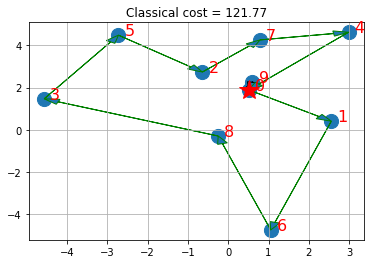

In [9]:
# Visualize the solution
def visualize_solution(xc, yc, x, C, n, K, title_str):
    plt.figure()
    plt.scatter(xc, yc, s=200)
    for i in range(len(xc)):
        plt.annotate(i, (xc[i] + 0.15, yc[i]), size=16, color='r')
    plt.plot(xc[0], yc[0], 'r*', ms=20)

    plt.grid()
    
    vehicle=0
    colours=['green','black','blue']
    lst_vehicles=[[0] for i in range(K)]
    ii_list=[ii for ii in range(0, n ** 2)]
    while len(ii_list)>0:
        for ii in ii_list:

            if x[ii] > 0:
                ix = ii // n
                iy = ii % n
                if ix==0:
                    lst_vehicles[vehicle].append(iy)
                    plt.arrow(xc[ix], yc[ix], xc[iy] - xc[ix], yc[iy] - yc[ix], length_includes_head=True, head_width=.25,ec=colours[vehicle])
                    vehicle+=1
                    ii_list.remove(ii)
                else:
                    for i in range(K):
                        if lst_vehicles[i].count(ix)>0:
                            lst_vehicles[i].append(iy)
                            plt.arrow(xc[ix], yc[ix], xc[iy] - xc[ix], yc[iy] - yc[ix], length_includes_head=True, head_width=.25,ec=colours[i])
                            ii_list.remove(ii)
                            break
            else:
                ii_list.remove(ii)
                    
    print('Routes: ',lst_vehicles)

    plt.title(title_str+' cost = ' + str(int(C * 100) / 100.))
    plt.show()    

if x is not None:
    visualize_solution(xc, yc, x, classical_cost, n, K, 'Classical')

If you have CPLEX, the solution shows the depot with a star and the selected routes for the vehicles with arrows. 

This code is part of the Vehicle Routing tutorial on the IBM Quantum Experience.

This code is licensed under the Apache License, Version 2.0. You may
obtain a copy of this license in the LICENSE.txt file in the root directory
of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
Any modifications or derivative works of this code must retain this
copyright notice, and modified files need to carry a notice indicating
that they have been altered from the originals.